# Train car - v1

data ; crop and resize  
ImageAugment  
network ; mobilenetv2, Dense 2  

train acc ; 99, val acc; 79,  max lb acc ; 80    


## train ready

In [30]:
import sys
import pandas as pd

from keras.applications import mobilenetv2
from keras.preprocessing import image
# import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Input, Model

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [58]:
modelpath='car.h5'
cache=False
basedir = './'

x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [59]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [60]:
imgwidth=224
imgheight=224

In [61]:
# cross validation
cvmode=1
datacnt = x_trainall.shape[0]
if cvmode==0:
    # 7000, 2990
    print('cvmode=0')
    x_train = x_trainall[:7000]
    y_train = y_trainall[:7000]
    x_val = x_trainall[7000:]
    y_val = y_trainall[7000:]
elif cvmode==1:
    print('cvmode=1')
    x_train = x_trainall[datacnt-7000:]
    y_train = y_trainall[datacnt-7000:]
    x_val = x_trainall[:datacnt-7000]
    y_val = y_trainall[:datacnt-7000]
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

(7000, 224, 224, 3) (7000,) (2990, 224, 224, 3) (2990,)
0 195


In [62]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [63]:
# Image Augumentation
batch_size=64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=True)

In [64]:
# checkpoint save weights in progress...
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
checkpoint_path='ckpt/check_{epoch:04d}.ckpt'
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, period=10)

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [65]:
force = False

if os.path.exists(modelpath) and force==False :
    cache=True
    print('cache model use... continuous!')
else:
    cache=False
    print('no cache model. create new model!')

cache model use... continuous!


In [66]:
# model
if cache==True:
    model = load_model(modelpath)
    print('load model...')
else:
    inputs = Input(shape=(224,224,3))
    net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet', pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)

    model = Model(inputs=inputs, outputs=net2)
    print('new model...')

model.summary()

load model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________________

In [67]:
##### model freeze
if cache==True:
    for layer in model.layers[:-5]:
        layer.trainable=False
    for layer in model.layers:
        print(layer, layer.trainable)
    model.summary()

<keras.engine.input_layer.InputLayer object at 0x7f7b536370b8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7b53637128> False
<keras.layers.convolutional.Conv2D object at 0x7f7b53637208> False
<keras.layers.normalization.BatchNormalization object at 0x7f7b53637240> False
<keras.layers.advanced_activations.ReLU object at 0x7f7b53637390> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f7b53637470> False
<keras.layers.normalization.BatchNormalization object at 0x7f7b53637588> False
<keras.layers.advanced_activations.ReLU object at 0x7f7b536375f8> False
<keras.layers.convolutional.Conv2D object at 0x7f7b536378d0> False
<keras.layers.normalization.BatchNormalization object at 0x7f7b53637908> False
<keras.layers.convolutional.Conv2D object at 0x7f7b53637a90> False
<keras.layers.normalization.BatchNormalization object at 0x7f7b53637ba8> False
<keras.layers.advanced_activations.ReLU object at 0x7f7b53637d30> False
<keras.layers.convolutional.ZeroPadding2D object

In [68]:
if False:
    model.load_weights('ckpt/check_0180.ckpt')

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
#epochs = 200
# hist = model.fit( x_train, y_train_onehot, batch_size=50, shuffle=True,  epochs=epochs, 
#                  verbose=1 , callbacks=[tensorboard], validation_data=[x_val, y_val_onehot] )
# 5, 
hist = model.fit_generator( train_generator, epochs = 500, validation_data=val_generator, 
                           callbacks=[cp_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Epoch 1/500
110/109 [==============================] - 50s 450ms/step - loss: 0.0316 - acc: 0.9943 - val_loss: 0.1415 - val_acc: 0.9669
Epoch 2/500
110/109 [==============================] - 47s 429ms/step - loss: 0.0523 - acc: 0.9885 - val_loss: 0.1571 - val_acc: 0.9656
Epoch 3/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0424 - acc: 0.9887 - val_loss: 0.1394 - val_acc: 0.9679
Epoch 4/500
110/109 [==============================] - 47s 428ms/step - loss: 0.0479 - acc: 0.9895 - val_loss: 0.1421 - val_acc: 0.9689
Epoch 5/500
110/109 [==============================] - 47s 428ms/step - loss: 0.0447 - acc: 0.9913 - val_loss: 0.1515 - val_acc: 0.9672
Epoch 6/500
110/109 [==============================] - 47s 429ms/step - loss: 0.0491 - acc: 0.9884 - val_loss: 0.1801 - val_acc: 0.9602
Epoch 7/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0464 - acc: 0.9911 - val_loss: 0.1780 - val_acc: 0.9602
Epoch 8/500
110/109 [===========================

Epoch 61/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0330 - acc: 0.9946 - val_loss: 0.2134 - val_acc: 0.9585
Epoch 62/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0220 - acc: 0.9945 - val_loss: 0.2605 - val_acc: 0.9605
Epoch 63/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0278 - acc: 0.9936 - val_loss: 0.2823 - val_acc: 0.9552
Epoch 64/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0298 - acc: 0.9943 - val_loss: 0.2439 - val_acc: 0.9585
Epoch 65/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0290 - acc: 0.9924 - val_loss: 0.2430 - val_acc: 0.9582
Epoch 66/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0350 - acc: 0.9929 - val_loss: 0.2181 - val_acc: 0.9632
Epoch 67/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0240 - acc: 0.9953 - val_loss: 0.2259 - val_acc: 0.9585
Epoch 68/500
110/109 [===================

110/109 [==============================] - 47s 427ms/step - loss: 0.0276 - acc: 0.9953 - val_loss: 0.3632 - val_acc: 0.9482
Epoch 180/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0213 - acc: 0.9963 - val_loss: 0.4265 - val_acc: 0.9388
Epoch 181/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0187 - acc: 0.9969 - val_loss: 0.3559 - val_acc: 0.9512
Epoch 182/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0207 - acc: 0.9966 - val_loss: 0.3449 - val_acc: 0.9522
Epoch 183/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0220 - acc: 0.9963 - val_loss: 0.3317 - val_acc: 0.9562
Epoch 184/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0166 - acc: 0.9979 - val_loss: 0.3756 - val_acc: 0.9522
Epoch 185/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0128 - acc: 0.9974 - val_loss: 0.3953 - val_acc: 0.9468
Epoch 186/500
110/109 [=========================

110/109 [==============================] - 47s 425ms/step - loss: 0.0303 - acc: 0.9956 - val_loss: 0.3921 - val_acc: 0.9535
Epoch 298/500
110/109 [==============================] - 47s 425ms/step - loss: 0.0248 - acc: 0.9951 - val_loss: 0.4752 - val_acc: 0.9441
Epoch 299/500
110/109 [==============================] - 47s 425ms/step - loss: 0.0349 - acc: 0.9959 - val_loss: 0.4559 - val_acc: 0.9472
Epoch 300/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0309 - acc: 0.9960 - val_loss: 0.4146 - val_acc: 0.9478
Epoch 301/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0231 - acc: 0.9966 - val_loss: 0.3746 - val_acc: 0.9525
Epoch 302/500
110/109 [==============================] - 47s 425ms/step - loss: 0.0206 - acc: 0.9964 - val_loss: 0.3914 - val_acc: 0.9542
Epoch 303/500
110/109 [==============================] - 47s 425ms/step - loss: 0.0184 - acc: 0.9970 - val_loss: 0.3606 - val_acc: 0.9535
Epoch 304/500
110/109 [=========================

110/109 [==============================] - 47s 426ms/step - loss: 0.0356 - acc: 0.9955 - val_loss: 0.3559 - val_acc: 0.9609
Epoch 416/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0160 - acc: 0.9976 - val_loss: 0.4544 - val_acc: 0.9482
Epoch 417/500
110/109 [==============================] - 47s 428ms/step - loss: 0.0330 - acc: 0.9954 - val_loss: 0.4891 - val_acc: 0.9448
Epoch 418/500
110/109 [==============================] - 47s 428ms/step - loss: 0.0304 - acc: 0.9961 - val_loss: 0.5190 - val_acc: 0.9462
Epoch 419/500
110/109 [==============================] - 47s 426ms/step - loss: 0.0265 - acc: 0.9963 - val_loss: 0.3988 - val_acc: 0.9535
Epoch 420/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0348 - acc: 0.9961 - val_loss: 0.4782 - val_acc: 0.9485
Epoch 421/500
110/109 [==============================] - 47s 427ms/step - loss: 0.0247 - acc: 0.9969 - val_loss: 0.4920 - val_acc: 0.9465
Epoch 422/500
110/109 [=========================

In [83]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
# or 
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

[0.47270005646357965, 0.9481605352765342]


In [84]:
model.save(modelpath)

In [85]:
# submission
x_test = np.load('x_test.npy')
predictions = model.predict( x_test/255. )
pdi = np.argmax(predictions, axis=1)
print(pdi, np.min(pdi), np.max(pdi))

[123 162 156 ...  43  49  93] 0 195


In [86]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,163
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


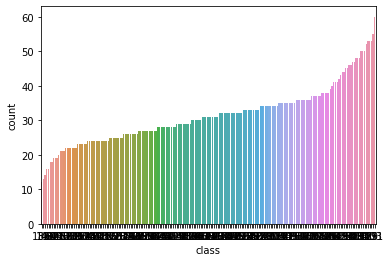

In [87]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)